In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

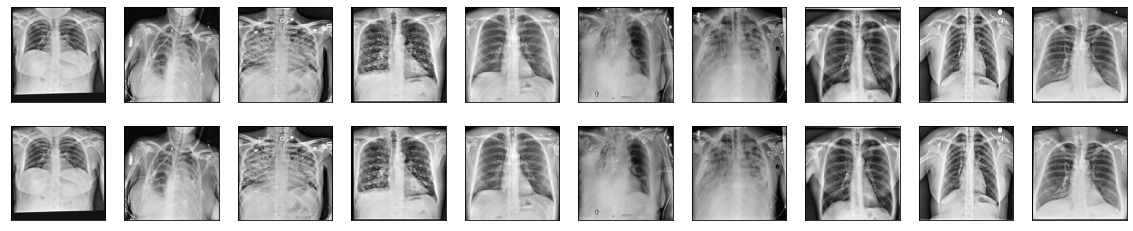

In [62]:
import glob
import imageio
import numpy as np
import cv2
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
sz,imgs=128,[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for png in pngs[:]:
    if len(imgs) % 100 == 0:
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
    img = imageio.imread(png)
    if len(img.shape) > 2:
        # print('{0} {1} -> '.format(img.shape, img.dtype))
        img = rgb2gray(img)
        img = img_as_ubyte(img)
        # print('{0} {1}'.format(img.shape, img.dtype))
        # continue
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
show_original_decoded(imgs[:10], imgs[:10], sz)

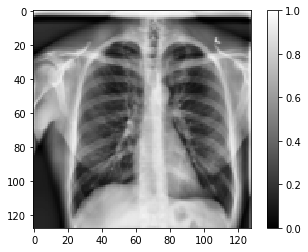

In [63]:
plt.figure()
plt.imshow(imgs[7].reshape((sz,sz)), cmap=plt.cm.gray)
plt.colorbar()
plt.grid(False)
plt.show()

In [43]:
from keras import backend as K

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [44]:
def build_autoencoder(sz, optimizer, loss):
    from keras.layers import Dense, Input, SpatialDropout2D
    from keras.layers import Conv2D, Flatten, Lambda
    from keras.layers import LocallyConnected2D, ZeroPadding2D
    from keras.layers import MaxPooling2D, UpSampling2D
    from keras.layers import Reshape, Conv2DTranspose
    from keras.layers import ActivityRegularization
    from keras.models import Model
    from keras.datasets import mnist
    from keras.losses import mse, binary_crossentropy
    from keras.utils import plot_model

    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(16, (5,5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = SpatialDropout2D(0.1)(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)    
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    # x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)
    print(shape)

    # generate latent vector Q(z|X)
    latent_dim = 8
    x = Flatten()(encoded_layer)
    x = Dense(latent_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    #x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (5,5), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder


In [ ]:
def vae_loss(y_true, y_pred):
    """Compute VAE loss, using either mse or crossentropy."""
    img_pixels = sz * sz
    use_mse = True
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

In [45]:
autoencoder, encode_only, decode_only = build_autoencoder(sz, 'adadelta', 
    # 'binary_crossentropy')
    'mean_squared_error')

(None, 8, 8, 4)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 128, 128, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 32)   4640        max_pooling2d_12[0][0]           
____________________________________________________________________________

In [64]:
import numpy as np
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(12072, 128, 128, 1) (1341, 128, 128, 1)


In [ ]:
autoencoder.fit(x_train, x_train, 
                epochs=1024, batch_size=128, 
                shuffle=True, validation_data=(x_test,x_test))

Train on 12072 samples, validate on 1341 samples
Epoch 1/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0138 - val_loss: 0.0151
Epoch 2/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 3/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 4/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 5/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0151
Epoch 6/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0138 - val_loss: 0.0152
Epoch 7/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0151
Epoch 8/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 9/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_l

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 77/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0151
Epoch 78/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 79/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 80/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0151
Epoch 81/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 82/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 83/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0151
Epoch 84/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 85/1024
12072/12072 [===============

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 152/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 153/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 154/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 155/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 156/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0151
Epoch 157/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 158/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 159/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0151
Epoch 160/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 227/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 228/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 229/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 230/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 231/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 232/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0137 - val_loss: 0.0152
Epoch 233/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 234/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 235/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 302/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 303/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 304/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0150
Epoch 305/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 306/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 307/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 308/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 309/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 310/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 377/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 378/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 379/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 380/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 381/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 382/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 383/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 384/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 385/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 452/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 453/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 454/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 455/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 456/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 457/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 458/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 459/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 460/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0155
Epoch 527/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 528/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 529/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 530/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 531/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 532/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 533/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 534/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 535/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 602/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 603/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0154
Epoch 604/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0154
Epoch 605/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 606/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 607/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 608/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 609/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 610/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 677/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 678/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 679/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0154
Epoch 680/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 681/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 682/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 683/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 684/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 685/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 752/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 753/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 754/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 755/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 756/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 757/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 758/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0154
Epoch 759/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 760/1024
12072/12072 [======

12072/12072 [==============================] - 15s 1ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 827/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0134 - val_loss: 0.0155
Epoch 828/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 829/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 830/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 831/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 832/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 833/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 834/1024
12072/12072 [==============================] - 15s 1ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 835/1024
12072/12072 [======

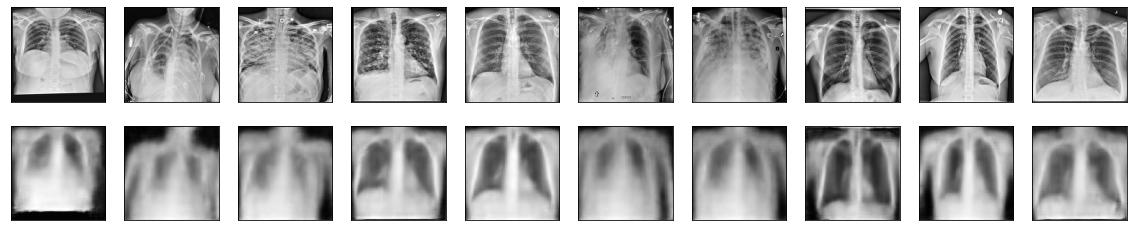

In [81]:
encode_only_imgs = encode_only.predict(x_test[:10])
if False:
    for n in range(10):
        print("shape of encoded = ", encode_only_imgs[2].shape)
        hist, bins = np.histogram(encode_only_imgs[2])
        print(hist)
        print(bins)
decoded_imgs = decode_only.predict(encode_only_imgs[2])
show_original_decoded(x_test[:10], decoded_imgs, sz)

In [82]:
import matplotlib.pyplot as plt
def g(**kwargs):
    plt.figure(2)
    latent = np.array([list(kwargs.values())])
    decoded = decode_only.predict(latent)
    plt.imshow(decoded.reshape(sz,sz))
    plt.gray()
    return kwargs['1']

In [83]:
from ipywidgets import interactive_output,Layout
import ipywidgets as widgets

In [84]:
%matplotlib inline
latent_dim = encode_only_imgs[2].shape[-1]
kwargs = {}
for k in range(latent_dim):
    kwargs[str(k)] = \
        widgets.FloatSlider(value=0,
                            min=-20.0,max=20.0,step=0.01,
                            orientation='vertical',
                            layout=Layout(padding='0%'))
w = interactive_output(g,kwargs)
display(widgets.HBox(list(kwargs.values()),layout=Layout(padding='0%')),w)

Output()